In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

In [2]:
%matplotlib inline

In [3]:
batch_size = 128
img_size = 32
channels = 3
nz = 100 #latent rep size
lr = 0.0002
beta1 = 0.5

Files already downloaded and verified


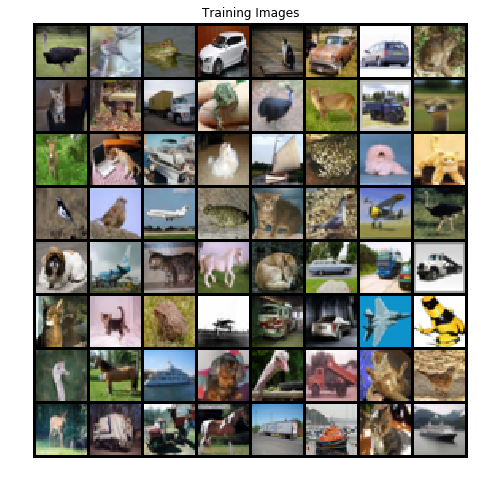

In [4]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform,)
a=np.arange(trainset.data.shape[0])
a=np.random.permutation(a)
b=45000

train_ds = Subset(trainset, a[:b])
val_ds = Subset(trainset, a[b:])
#trainset = torchvision.datasets.CIFAR10(root='./data', =True,
#                                        download=True)
batch_size2=2000
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size2,
                                         shuffle=True, num_workers=4)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

import torchvision.utils as vutils
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, img_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 256*4*4
            nn.ConvTranspose2d(img_size * 8, img_size* 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 128*8*8
            nn.ConvTranspose2d( img_size * 4, img_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 64*16*16
            nn.ConvTranspose2d( img_size * 2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # out- 3*32*32
        )
        
    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3*32*32 
            nn.Conv2d(3, img_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_size, 2*img_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_size*2, img_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size*2, 1, 4, 1, 0, bias=False),
            #nn.Flatten(-1,10)
            nn.Sigmoid()
            )
    def forward(self, input):
        return self.main(input)

In [7]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

from inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('path', type=str, nargs=2,
                    help=('Path to the generated images or '
                          'to .npz statistic files'))
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('-c', '--gpu', default='', type=str,
                    help='GPU to use (leave blank for CPU only)')


def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    pred_arr = np.empty((len(files), dims))

    for i in tqdm(range(0, len(files), batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

    
    
def act_stats(data1,data2,batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = compute_stats(data1, model, batch_size,
                                         dims, cuda)
    m2, s2 = compute_stats(data2, model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value
    
def compute_stats(data, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)
        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

def compute_mean_cov(data,batch_size=50,
                                    dims=2048, cuda=True, verbose=False):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

In [8]:
netG=Generator()
netG.load_state_dict(torch.load('models/DCGAN_g.pt',device))
netD=Discriminator()
netD.load_state_dict(torch.load('models/DCGAN_d.pt',device))

<All keys matched successfully>

In [9]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fake = netG(fixed_noise).detach().cpu()

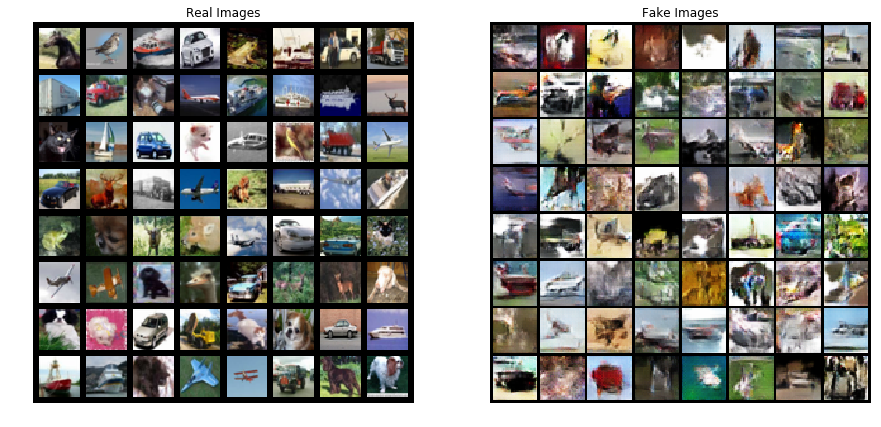

calculating FID


  0%|          | 0/40 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
plt.show()

print('calculating FID')
data1=iter(valloader).next()[0].numpy()
mu1,cov1=compute_mean_cov(data1/2+0.5,cuda=False)
with torch.no_grad():
    data2=netG(torch.randn(1000, nz, 1, 1, device=device))
data2=data2.cpu().numpy()
mu2,cov2=compute_mean_cov(data2/2+0.5,cuda=False)
fid=calculate_frechet_distance(mu1,cov1,mu2,cov2)
print('FID score :',fid)